In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
def display_progress_bar(n_tot, n_prog) :
    from time import sleep
    progress = math.ceil((n_prog + 1) * 100 / n_tot)
    sys.stdout.write('\r')
    sys.stdout.write("[%-100s] %d%%" %('='*progress, progress))
    sys.stdout.flush()
    sleep(0.25)

In [3]:
def func(date_time) :
    """
    Routine converting time of day to number of seconds
    """
    seconds = date_time.hour * 3600 + date_time.minute * 60 + date_time.second
    return seconds

In [4]:
def display_metrics(description, model, X_test, y_test) :
    """
    Routine to automate metrics calculation and display
    """
    prediction = model.predict(X_test)
    # Get Root Mean Squared Error
    mse = metrics.mean_squared_error(y_test, prediction)
    rmse = math.sqrt(mse)
    # Get Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test, prediction)
    # Get Dtermination Coefficient
    r2 = metrics.r2_score(y_test, prediction)
    # Display
    print(description + " : RMSE : %.2f, MAE : %.2f, R² : %.2f" %(rmse, mae, r2))
    return prediction

In [5]:
def pred_mse(test, predicted) :
    """
    Looking at each prediction and computing mse/rmse
    Return statistics on mse prediction
    """
    predict_df = pd.DataFrame()
    predict_df.loc[:, 'target'] = test
    predict_df.loc[:, 'pred'] = predicted
    predict_df.loc[:, 'mse'] = predict_df.loc[:, 'pred'].sub(predict_df.loc[:, 'target'], axis=0).apply(lambda x : math.pow(x, 2))
    return predict_df, predict_df.loc[:, 'mse'].describe()

In [6]:
def grid_search(X_train, y_train, X_test, y_test, model, n_alphas, logmin, logmax) :
    """
    Grid search function
    """

    # Set n alphas for a grid search crossed-validation
    alphas = np.logspace(logmin, logmax, n_alphas)
    
    # Initialisations
    count=0                              # For progression display
    best_rmse = 9999                     # Best RMSE of the grid search
    best_alpha = 0                       # Best Alpha of the grid search
    best_ridge = copy.deepcopy(model)    # Best model of the grid search

    # Grid search
    for a in alphas :
        # Set model
        model.set_params(alpha=a)
        model.fit(X_train, y_train)
        # Get RMSE
        mse_temp = metrics.mean_squared_error(y_test, model.predict(X_test))
        rmse_temp = math.sqrt(mse_temp)
        # Look for best alpha parameter
        if rmse_temp < best_rmse :
            best_alpha = a
            best_ridge = copy.deepcopy(model)

        display_progress_bar(len(alphas),count)
        count+=1
    
    return best_ridge, best_alpha

In [7]:
def time_cross_validation(model, X, y, n_alphas, n_splits, gs=True) :
    """
    Cross validation function with a grid search over alpha parameter for Ridge Regression
    """
    
    # Create time splits
    tscv = model_selection.TimeSeriesSplit(n_splits=n_splits)

    # Initialise outputs
    errors_cv = []
    alphas_cv = []
    
    # Initialise splits count
    num_split = 1

    # Time cross--validation
    for train_index, test_index in tscv.split(X):
        # Create train and test sets
        X_train_cv, X_test_cv = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        if gs :
            best_model, best_alpha = grid_search(X_train_cv, y_train_cv, X_test_cv, y_test_cv, model,
                                                 n_alphas, 1, 10)
        else :
            model.fit(X_train_cv, y_train_cv)
            best_model = model
            best_alpha = NaN
        
        # Get split model errors with best grid search model
        mse_cv = metrics.mean_squared_error(y_test_cv, best_model.predict(X_test_cv))
        rmse_cv = math.sqrt(mse_cv)
        mae_cv = metrics.mean_absolute_error(y_test_cv, best_model.predict(X_test_cv))
        r2_cv = metrics.r2_score(y_test_cv, best_model.predict(X_test_cv))
        # Save errors
        errors_cv.append([mae_cv, rmse_cv, r2_cv])
        # Save best alpha for this time split
        alphas_cv.append(best_alpha)
        # Display
        display_metrics("\nModel regression for split number " + str(num_split), best_model, X_test_cv, y_test_cv)
        # Loop
        num_split += 1
        
    return errors_cv, alphas_cv

# 1) Importations

In [8]:
%pylab inline
import pandas as pd
import os
import sys
import seaborn as sns
from sklearn import preprocessing, metrics, linear_model, model_selection, dummy
import scipy as sp
import math
import time
import copy
from dateutil import parser
import pickle

Populating the interactive namespace from numpy and matplotlib


# 2) Data loading

In [9]:
# Getting current path
path = os.getcwd()

# Verifying data presence
try :
#     data = pd.read_csv(path + "/data/data_airlines.csv")
#     with open(path + '/data/data_airlines.pkl', 'rb') as f :
    with open(path + '/data/data_more_features.pkl', 'rb') as f :
        data = pickle.load(f)
except FileNotFoundError :
    print("Please check if the file 'data_airlines.csv' is in the 'data' folder at the current location")

# 3) Data preparation

# 3.1) Overview

In [10]:
print(data.shape)
data.head()

(4518157, 9)


,ARR_DELAY_NEW,DEST_AIRPORT_ID,DISTANCE,ORIGIN_AIRPORT_ID,TAIL_NUM,UNIQUE_CARRIER,DATE_TIME,TIME_SECONDS,ARR_TIME_SECS
5480165,10.0,11298.0,1235.0,12892,N860AA,AA,2016-01-01 00:10:00,600,18096.0
5482988,0.0,11057.0,1773.0,14107,N157UW,AA,2016-01-01 00:15:00,900,21696.0
5476021,0.0,11057.0,2296.0,14771,N558UW,AA,2016-01-01 00:15:00,900,29280.0
5661633,0.0,13930.0,1846.0,14771,N472UA,UA,2016-01-01 00:24:00,1440,25344.0
5444953,0.0,13303.0,2342.0,12892,N864AA,AA,2016-01-01 00:30:00,1800,31008.0


Some feature are categorical : need for encoding

# 3.2) Encoding categorical features

Label encoding airlines

In [11]:
le = preprocessing.LabelEncoder()
label_airlines = le.fit_transform(data.UNIQUE_CARRIER)

One Hot encoding airlines from label encoding

In [12]:
oh_airlines = pd.get_dummies(label_airlines)
# Reindex
oh_airlines.index = data.index

Label encoding aircrafts

In [13]:
le = preprocessing.LabelEncoder()
label_aircrafts = pd.DataFrame(le.fit_transform(data.TAIL_NUM), columns=['TAIL_NUM'])
# Reindex
label_aircrafts.index = data.index
# Concat
data_reg = pd.concat((oh_airlines, label_aircrafts), axis=1)
# Relieve Memory
del label_airlines, oh_airlines, label_aircrafts

One Hot encoding departure airports

In [14]:
oh_dep_airport = pd.get_dummies(data.ORIGIN_AIRPORT_ID)
# Concat
data_reg = pd.concat((data_reg, oh_dep_airport), axis=1)
# Relieve Memory
del oh_dep_airport

One Hot encoding arrival airports

In [15]:
# oh_arr_airport = pd.get_dummies(data.DEST_AIRPORT_ID)
# # Concat
# data_reg = pd.concat((data_reg, oh_arr_airport), axis=1)
# # Relieve Memory
# del oh_arr_airport

Standardise numerical features

In [16]:
std_scale = preprocessing.StandardScaler().fit(data.loc[:, ['TIME_SECONDS', 'ARR_TIME_SECS', 'DISTANCE']].values)
data_num = pd.DataFrame(std_scale.transform(data.loc[:, ['TIME_SECONDS', 'ARR_TIME_SECS', 'DISTANCE']].values), columns=['DEP_TIME_SECS_STD', 'ARR_TIME_SECS_STD', 'DISTANCE_STD'])
# Reindex
data_num.index = data.index
# Concat
data_reg = pd.concat((data_reg, data_num), axis=1)
# Relieve Memory
del data_num

Concatenate everything into processed data

In [17]:
data_reg = pd.concat((data_reg, data.loc[:, ['ARR_DELAY_NEW']]), axis=1)
# Relieve Memory
del data
display(data_reg.head())

,0,1,2,3,4,5,6,7,8,9,...,15380,15389,15412,15624,15919,16218,DEP_TIME_SECS_STD,ARR_TIME_SECS_STD,DISTANCE_STD,ARR_DELAY_NEW
5480165,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-2.703141,-1.992056,0.538910,10.0
5482988,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-2.686161,-1.799513,1.388456,0.0
5476021,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-2.686161,-1.393889,2.214315,0.0
5661633,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,-2.655597,-1.604403,1.503729,0.0
5444953,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-2.635220,-1.301469,2.286953,0.0


Set Target

In [18]:
# Target : arrival delay
y = data_reg.loc[:, 'ARR_DELAY_NEW']
X = data_reg.loc[:, data_reg.columns  != 'ARR_DELAY_NEW']

Split in train/test sets : Learn over 70% of the year to predict the future 30% of the year

In [19]:
test_size = 0.3
n_train = math.floor(X.shape[0] * (1 - test_size))

X_train = X.iloc[:n_train, :]
X_test = X.iloc[n_train:, :]

y_train = y.iloc[:n_train]
y_test = y.iloc[n_train:]

Save Memory

In [20]:
del data_reg#,X, y, 

# 4) First models

# 4.1) Dummy model : Predicting the mean

In [56]:
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test)

In [57]:
# Get the errors
display_metrics("Dummy mean prediction on training set", dum, X_train, y_train)
display_metrics("Dummy mean prediction on testing set", dum, X_test, y_test)
# Get the mse composition
pred_df_dum, mse_stats_df_dum = pred_mse(y_test, y_pred_dum)

Dummy mean prediction on training set : RMSE : 21.13, MAE : 12.87, R² : 0.00
Dummy mean prediction on testing set : RMSE : 19.87, MAE : 12.28, R² : -0.00


In [58]:
# Getting mean MSE for 2-min delay windows
delays = []
mean_mse_delay_dum = []
delay = 0
for i in range(70) :
    mean_mse_delay_dum.append(pred_df_dum.loc[:, 'mse'][pred_df_dum.loc[:, 'target'].between(delay, delay+2)].mean())
    delays.append(delay)
    delay += 2
sorted_pred_df_dum = pred_df_dum.sort_values(by=['mse'], ascending=False)

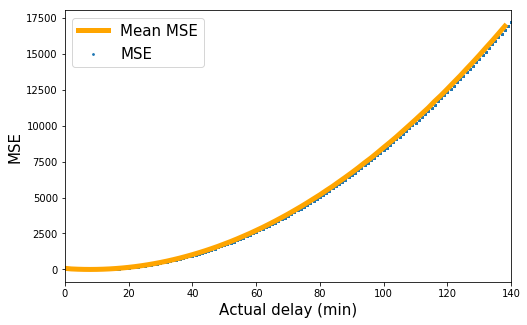

In [59]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(sorted_pred_df_dum.target, sorted_pred_df_dum.mse, label='MSE', s=3)
ax.set_xlabel("Actual delay (min)", fontsize=15)
ax.set_ylabel("MSE", fontsize=15)
ax.set_xlim((0,140));
ax.plot(delays, mean_mse_delay_dum, label='Mean MSE', color='orange', linewidth=5)
ax.legend(fontsize=15);

From this simple plot we can see that this dummy model : 
* Performs poorly as delay increases
* Performs best for delays between 0 and 20 min, which may be an interesting feature as most delays are small delays

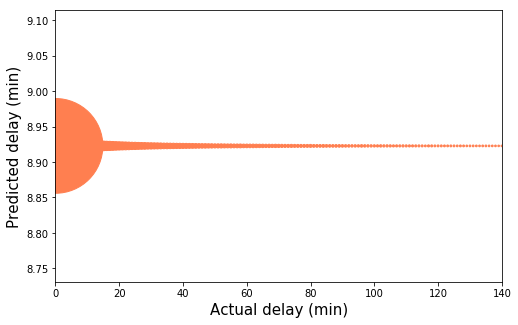

In [60]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(y_test), list(y_pred_dum)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 0.01
    else:
        sizes[(yt, yp)] = 0.01

keys = sizes.keys()
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter([k[0] for k in keys], # vraie valeur (abscisse)
            [k[1] for k in keys], # valeur predite (ordonnee)
            s=[sizes[k] for k in keys], # taille du marqueur
            color='coral')

ax.set_xlabel("Actual delay (min)", fontsize=15)
ax.set_ylabel("Predicted delay (min)", fontsize=15)
ax.set_xlim((0,140));

Save Memory

In [40]:
del y_pred_dum, pred_df_dum, sorted_pred_df_dum

# 4.3) Baseline : Linear regression with selected features

This will be our baseline model : a simple linear regression

In [41]:
lr = linear_model.LinearRegression()
# Training the model with training set
lr.fit(X_train, y_train);

In [42]:
display_metrics("Linear regression on training set", lr, X_train, y_train)
display_metrics("Linear regression on testing set", lr, X_test, y_test);

Linear regression on training set : RMSE : 20.79, MAE : 12.45, R² : 0.03
Linear regression on testing set : RMSE : 19.73, MAE : 12.05, R² : 0.01


The score may be poor, the RMSE is close on both training and testing sets, thus the model might be lausy representation of the data but consistent anyhow

Looking closely at our prediction error behaviour : mean squared error

In [43]:
y_test_predict = lr.predict(X_test)
pred_df, mse_stats_df = pred_mse(y_test, y_test_predict)
mse_stats_df

count    1.355448e+06
mean     3.892597e+02
std      1.495334e+03
min      7.854280e-11
25%      2.727532e+01
50%      7.244452e+01
75%      1.491100e+02
max      1.925446e+04
Name: mse, dtype: float64

So the max mean squared error is quite high ! Some predictions are quite bad. The mean and the median however (respectively 6e-3 and 80 are not that high values which may be a good point).

In [44]:
# Getting mean RMSE for 2-min delay windows
delays = []
mean_mse_delay = []
delay = 0
for i in range(70) :
    mean_mse_delay.append(pred_df.loc[:, 'mse'][pred_df.loc[:, 'target'].between(delay, delay+2)].mean())
    delays.append(delay)
    delay += 2
sorted_pred_df = pred_df.sort_values(by=['mse'], ascending=False)

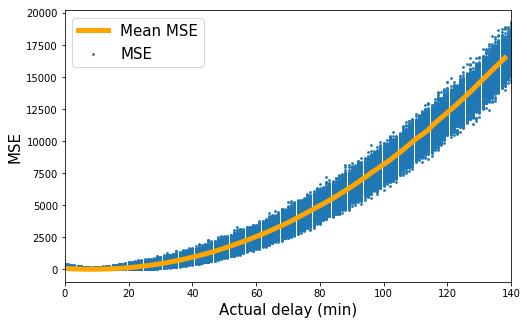

In [53]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(sorted_pred_df.target, sorted_pred_df.mse, label='MSE', s=3)
ax.set_xlabel("Actual delay (min)", fontsize=15)
ax.set_ylabel("MSE", fontsize=15)
ax.set_xlim((0,140));
ax.plot(delays, mean_mse_delay, label='Mean MSE', color='orange', linewidth=5)
ax.legend(fontsize=15);

Chocking : We find the same behaviour as our dummy mean-predicting model. This Linear Regression model seems to be empty.

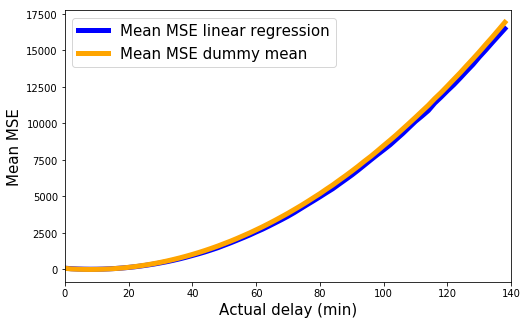

In [55]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(delays, mean_mse_delay, label='Mean MSE linear regression', color='blue', linewidth=5)
ax.plot(delays, mean_mse_delay_dum, label='Mean MSE dummy mean', color='orange', linewidth=5)
ax.legend(fontsize=15)
ax.set_xlabel("Actual delay (min)", fontsize=15)
ax.set_ylabel("Mean MSE", fontsize=15)
ax.set_xlim((0,140));
ax.legend(fontsize=15);

# 5) Ridge Regression

Let's look at a Ridge Regression and see how it manages to reduce the influence of some features

In [61]:
n_alphas = 10
alphas = np.logspace(1, 10, n_alphas)
ridge = linear_model.Ridge()

coefs = []
errors = []
count=0
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    mse = metrics.mean_squared_error(y_test, ridge.predict(X_test))
    rmse = math.sqrt(mse)
    mae = metrics.mean_absolute_error(y_test, ridge.predict(X_test))
    r2 = metrics.r2_score(y_test, ridge.predict(X_test))
    errors.append([mae, rmse, r2])
    display_progress_bar(len(alphas),count)
    count+=1

[====================================================================================================] 100%

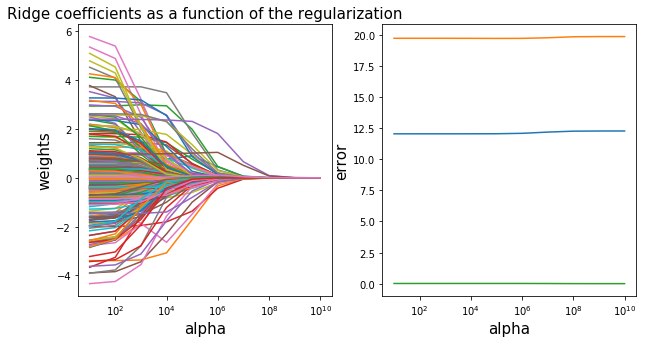

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,5))

ax1.plot(alphas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('alpha', fontsize=15)
ax1.set_ylabel('weights', fontsize=15)
ax1.set_title('Ridge coefficients as a function of the regularization', fontsize=15)
ax1.axis('tight')

ax2.plot(alphas, errors)
ax2.set_xscale('log')
ax2.set_xlabel('alpha', fontsize=15)
ax2.set_ylabel('error', fontsize=15)
plt.axis('tight');

The Ridge regularisation has reduced the weight of nearly every feature except for the departure time of day in seconds (which is still reduced to 0.001). The outcome is not better than our linear regression baseline, and regularisation even tends to worsen the results

In [86]:
X_train.iloc[:,[0,214,215,216]].columns

Index([0, 'DEP_TIME_SECS_STD', 'ARR_TIME_SECS_STD', 'DISTANCE_STD'], dtype='object')

In [91]:
final_coefs = coefs[-1]
final_coefs[(-final_coefs).argsort()][:5]
X_train.iloc[:,(-final_coefs).argsort()[:5]].columns

Index(['DEP_TIME_SECS_STD', 'ARR_TIME_SECS_STD', 0, 'DISTANCE_STD', 2], dtype='object')

In [93]:
errors

[[12.046983227204498, 19.729632178618054, 0.012743733795572476],
 [12.046919170243596, 19.72938346915575, 0.012768624115400029],
 [12.047272026224814, 19.72841517513859, 0.012865525955071733],
 [12.04856829922698, 19.72552358952672, 0.01315487252790759],
 [12.053449119337737, 19.71929632463499, 0.0137778598932915],
 [12.087214383300836, 19.72366365126565, 0.013340964873478023],
 [12.185059229749118, 19.771217428830518, 0.0085775571778135],
 [12.260706664201301, 19.851363024989087, 0.0005235068126338005],
 [12.273256275654514, 19.86706805456484, -0.0010585525131689977],
 [12.274643395868017, 19.86877577981081, -0.001230657066472185]]

# 6) Lasso Regression

Let's look at a Lasso Regression and see how it manages to set the influence of features to 0

In [65]:
n_alphas = 4
alphas = np.logspace(-1, 2, n_alphas)
lasso = linear_model.Lasso()

coefs_l = []
errors_l = []
count=0
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs_l.append(lasso.coef_)
    mse = metrics.mean_squared_error(y_test, lasso.predict(X_test))
    rmse = math.sqrt(mse)
    mae = metrics.mean_absolute_error(y_test, lasso.predict(X_test))
    r2 = metrics.r2_score(y_test, lasso.predict(X_test))
    errors_l.append([mae, rmse, r2])
    display_progress_bar(len(alphas),count)
    count+=1

[====================================================================================================] 100%

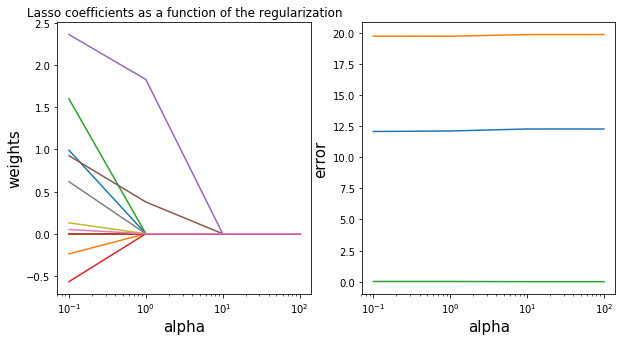

In [66]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,5))

ax1.plot(alphas, coefs_l)
ax1.set_xscale('log')
ax1.set_xlabel('alpha', fontsize=15)
ax1.set_ylabel('weights', fontsize=15)
ax1.set_title('Lasso coefficients as a function of the regularization')
ax1.axis('tight')

ax2.plot(alphas, errors_l)
ax2.set_xscale('log')
ax2.set_xlabel('alpha', fontsize=15)
ax2.set_ylabel('error', fontsize=15)
plt.axis('tight');

Similar to Ridge : Lasso is not using our features, it is therefore not relevant to use here. But it is striking to see that None of our feature is needed for the model, which feels wrong

In [67]:
errors_l

[[12.073253405708334, 19.739279902600973, 0.011777967717193749],
 [12.115436289653879, 19.734037124717766, 0.012302844064883689],
 [12.274891982322856, 19.869035689518462, -0.0012568520643245762],
 [12.276023039960382, 19.869783371373966, -0.0013322090849863244]]

# 7) Time cross validation with Ridge Regression

Ridge does not do a better job that a simple Linear Regression but we will try to improve its performances with a cross validation over our time series

Perform grid search for alpha coefficient over splits of crossed validation

Looking for the influence of cross-validation settings over the model performance

In [19]:
# Getting back the objects:
with open(path + '/data/objs_cv_ridge.pkl', 'rb') as f :
    splits, rmse_split, mae_split = pickle.load(f)

In [21]:
splits = [2, 3, 4, 5, 6, 7, 8, 9, 10]
mae_split = []
rmse_split = []
r2_split = []

# Model
model = linear_model.LinearRegression()
model = linear_model.Ridge()

for split in splits :
    print("Cross validation with %i time splits" % split)
    errors_splits, alphas_splits = time_cross_validation(model, X, y, 5, split, gs=False)
    
    errors_array = np.array(errors_splits)
    
    mae_split.append(errors_array[:,0].mean())
    rmse_split.append(errors_array[:,1].mean())
    r2_split.append(errors_array[:,2].mean())
    
    print("Mean RMSE %.2f" % errors_array[:,1].mean())

Cross validation with 2 time splits

Model regression for split number 1 : RMSE : 22.52, MAE : 12.82, R² : 0.02

Model regression for split number 2 : RMSE : 19.51, MAE : 12.02, R² : 0.01
Mean RMSE 21.02
Cross validation with 3 time splits

Model regression for split number 1 : RMSE : 20.31, MAE : 11.77, R² : 0.02

Model regression for split number 2 : RMSE : 22.11, MAE : 12.77, R² : 0.03

Model regression for split number 3 : RMSE : 19.83, MAE : 12.07, R² : 0.01
Mean RMSE 20.75
Cross validation with 4 time splits

Model regression for split number 1 : RMSE : 19.41, MAE : 11.20, R² : 0.02

Model regression for split number 2 : RMSE : 23.34, MAE : 13.19, R² : 0.02

Model regression for split number 3 : RMSE : 19.78, MAE : 11.97, R² : 0.02

Model regression for split number 4 : RMSE : 20.44, MAE : 12.28, R² : 0.01
Mean RMSE 20.74
Cross validation with 5 time splits

Model regression for split number 1 : RMSE : 19.82, MAE : 11.27, R² : 0.02

Model regression for split number 2 : RMSE : 21

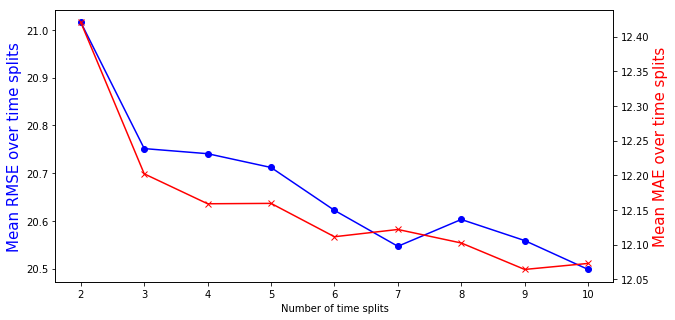

In [22]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(splits, rmse_split, 'bo-')

ax2 = ax1.twinx()
ax2.plot(splits, mae_split, 'rx-')
ax1.set_xlabel("Number of time splits")
ax1.set_ylabel("Mean RMSE over time splits", color='b', fontsize=15)
ax2.set_ylabel("Mean MAE over time splits", color='r', fontsize=15);

The computing has been long but the outcome shows how cross-validation improves the model performance. However looking at the scale of the RMSE reduction, one can ask if such a small gain is really worth the trouble as it might be more relevant to wonder about the behaviour of the model itself.

In [ ]:
# Saving the objects:
with open(path + '/data/objs_cv_lr.pkl', 'wb') as f :  
    pickle.dump([splits, rmse_split, mae_split], f)

# 8) Other Ridge models

In the exploratory phase we aknowledged the influence of the departure airport and the airline carrying the flight. We will now try to observe if selecting one airport or one airline or both improves the Ridge regression performances.

# 8.1) Same data but ONE airport, ALL airlines

1) Loading dataframe (pickle)

In [118]:
with open(path + '/data/data_2016_1_aiport.pkl', 'rb') as f :
    data_1_airport = pickle.load(f)
print("%i entries for this airport" % data_1_airport.shape[0])
data_1_airport.head(2)

366245 entries for this airport


,TAIL_NUM,UNIQUE_CARRIER,ORIGIN_CITY_NAME,ARR_DELAY_NEW,DISTANCE,DATE_TIME,TIME_SECONDS,ARR_TIME_SECS
126697,N506NK,NK,"Atlanta, GA",8.0,404.0,2016-01-01 06:00:00,21600,27120.0
332324,N947FR,F9,"Atlanta, GA",0.0,666.0,2016-01-01 06:05:00,21900,29760.0


2) Encoding airlines

In [119]:
le = preprocessing.LabelEncoder()
label_airlines = le.fit_transform(data_1_airport.UNIQUE_CARRIER)

3) One Hot encoding airlines from label encoding

In [105]:
oh_airlines = pd.get_dummies(label_airlines)

4) Standardise numerical features

In [106]:
std_scale = preprocessing.StandardScaler().fit(data_1_airport.loc[:, ['TIME_SECONDS', 'ARR_TIME_SECS', 'DISTANCE']].values)
data_num_1_airport = pd.DataFrame(std_scale.transform(data_1_airport.loc[:, ['TIME_SECONDS', 'ARR_TIME_SECS', 'DISTANCE']].values), columns=['DEP_TIME_SECS_STD', 'ARR_TIME_SECS_STD', 'DISTANCE_STD'])
# Reindex
data_num_1_airport.index = oh_airlines.index
# Concat
data_1_airport_reg = pd.concat((oh_airlines, data_num_1_airport), axis=1)

5) Reindex dataframe

In [107]:
data_1_airport.index = oh_airlines.index

6) Concatenate everything into processed data

In [108]:
data_1_airport_reg = pd.concat((data_1_airport_reg, data_1_airport.loc[:, 'ARR_DELAY_NEW']), axis=1)
display(data_1_airport_reg.head(2))

,0,1,2,3,4,5,6,7,8,DEP_TIME_SECS_STD,ARR_TIME_SECS_STD,DISTANCE_STD,ARR_DELAY_NEW
0,0,0,0,0,0,1,0,0,0,-1.887855,-1.635402,-0.524538,8.0
1,0,0,0,0,1,0,0,0,0,-1.870178,-1.493882,0.034261,0.0


In [109]:
# Target : arrival delay
y = data_1_airport_reg.loc[:, 'ARR_DELAY_NEW']
X = data_1_airport_reg.loc[:, data_1_airport_reg.columns  != 'ARR_DELAY_NEW']

7) Cross validation

In [110]:
splits = [2, 3, 4, 5, 6, 7, 8, 9, 10]
mae_split = []
rmse_split = []
r2_split = []

# Model
ridge = linear_model.Ridge()

for split in splits :
    print("Cross validation with %i time splits" % split)
    errors_splits, alphas_splits = time_cross_validation(ridge, X, y, 5, split)
    
    errors_array = np.array(errors_splits)
    
    mae_split.append(errors_array[:,0].mean())
    rmse_split.append(errors_array[:,1].mean())
    r2_split.append(errors_array[:,2].mean())
    
    print("Mean RMSE %.2f" % errors_array[:,1].mean())

Cross validation with 2 time splits
[====================================================================================================] 100%
Model regression for split number 1 : RMSE : 22.76, MAE : 12.19, R² : -0.02
[====================================================================================================] 100%
Model regression for split number 2 : RMSE : 16.11, MAE : 10.09, R² : -0.02
Mean RMSE 19.44
Cross validation with 3 time splits
[====================================================================================================] 100%
Model regression for split number 1 : RMSE : 18.81, MAE : 10.39, R² : -0.00
[====================================================================================================] 100%
Model regression for split number 2 : RMSE : 22.32, MAE : 12.27, R² : -0.01
[====================================================================================================] 100%
Model regression for split number 3 : RMSE : 16.19, MAE : 9.91, R² :

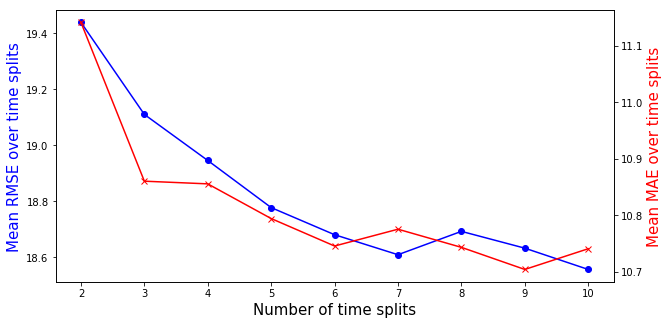

In [111]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(splits, rmse_split, 'bo-')

ax2 = ax1.twinx()
ax2.plot(splits, mae_split, 'rx-')
ax1.set_xlabel("Number of time splits", fontsize=15)
ax1.set_ylabel("Mean RMSE over time splits", color='b', fontsize=15)
ax2.set_ylabel("Mean MAE over time splits", color='r', fontsize=15);

The CV displays a best result for 7 time splits, but the model seems worse than the main Ridge Regression with all airports and all airlines.

# 8.2) Same data but ONE airline, ONE airport

1) Loading dataframe (pickle)

In [120]:
with open(path + '/data/data_2016_1_airline_1_aiport.pkl', 'rb') as f :
    data_1_airline_1_aiport = pickle.load(f)
print("%i entries for this airport" % data_1_airline_1_aiport.shape[0])
data_1_airline_1_aiport.head(2)

80917 entries for this airport


,TAIL_NUM,ORIGIN_CITY_NAME,ARR_DELAY_NEW,DISTANCE,TIME_SECONDS,ARR_TIME_SECS
339550,N707SA,"Chicago, IL",0.0,1521.0,22500,30240.0
339642,N8645A,"Chicago, IL",0.0,997.0,25200,39360.0


2) Standardise numerical features

In [124]:
std_scale = preprocessing.StandardScaler().fit(data_1_airline_1_aiport.loc[:, ['TIME_SECONDS', 'ARR_TIME_SECS', 'DISTANCE']].values)
data_num_1_airline_1_airport = pd.DataFrame(std_scale.transform(data_1_airline_1_aiport.loc[:, ['TIME_SECONDS', 'ARR_TIME_SECS', 'DISTANCE']].values), columns=['DEP_TIME_SECS_STD', 'ARR_TIME_SECS_STD', 'DISTANCE_STD'])
# Reindex
data_num_1_airline_1_airport.index = data_1_airline_1_aiport.index
# Concat
data_1_airport_reg = pd.concat((data_1_airline_1_aiport['ARR_DELAY_NEW'], data_num_1_airline_1_airport), axis=1)

In [126]:
data_1_airport_reg.head(2)

,ARR_DELAY_NEW,DEP_TIME_SECS_STD,ARR_TIME_SECS_STD,DISTANCE_STD
339550,0.0,-1.575404,-1.140637,1.489495
339642,0.0,-1.426590,-0.718927,0.377094


In [127]:
# Target : arrival delay
y = data_1_airline_1_aiport.loc[:, 'ARR_DELAY_NEW']
X = data_1_airport_reg.loc[:, data_1_airport_reg.columns  != 'ARR_DELAY_NEW']

3) Cross validation

In [128]:
splits = [2, 3, 4, 5, 6, 7, 8, 9, 10]
mae_split = []
rmse_split = []
r2_split = []

# Model
ridge = linear_model.Ridge()

for split in splits :
    print("Cross validation with %i time splits" % split)
    errors_splits, alphas_splits = time_cross_validation(ridge, X, y, 5, split)
    
    errors_array = np.array(errors_splits)
    
    mae_split.append(errors_array[:,0].mean())
    rmse_split.append(errors_array[:,1].mean())
    r2_split.append(errors_array[:,2].mean())
    
    print("Mean RMSE %.2f" % errors_array[:,1].mean())

Cross validation with 2 time splits
[====================================================================================================] 100%
Model regression for split number 1 : RMSE : 22.35, MAE : 12.24, R² : -0.04
[====================================================================================================] 100%
Model regression for split number 2 : RMSE : 17.28, MAE : 10.98, R² : -0.00
Mean RMSE 19.82
Cross validation with 3 time splits
[====================================================================================================] 100%
Model regression for split number 1 : RMSE : 18.40, MAE : 10.31, R² : -0.01
[====================================================================================================] 100%
Model regression for split number 2 : RMSE : 21.72, MAE : 12.31, R² : -0.02
[====================================================================================================] 100%
Model regression for split number 3 : RMSE : 17.72, MAE : 11.07, R² 

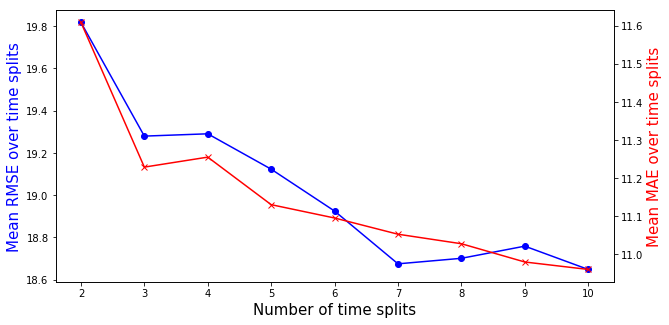

In [129]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(splits, rmse_split, 'bo-')

ax2 = ax1.twinx()
ax2.plot(splits, mae_split, 'rx-')
ax1.set_xlabel("Number of time splits", fontsize=15)
ax1.set_ylabel("Mean RMSE over time splits", color='b', fontsize=15)
ax2.set_ylabel("Mean MAE over time splits", color='r', fontsize=15);

The CV displays a best result for 10 time splits, AND the model seems better than the main Ridge Regression with all airports and all airlines

BUT, this is only a regression model toward departure time of the day

# 8.3) Same data but ONE airline, ALL airports

1) Loading dataframe (pickle)

In [130]:
with open(path + '/data/data_2016_1_airline.pkl', 'rb') as f :
    data_1_airline = pickle.load(f)
print("%i entries for this airport" % data_1_airline.shape[0])
data_1_airline.head(2)

1265267 entries for this airport


,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,ARR_DELAY_NEW,DISTANCE,TIME_SECONDS,ARR_TIME_SECS
338103,N551WN,12391,"Islip, NY",0.0,1052.0,19800,31200.0
337880,N210WN,11697,"Fort Lauderdale, FL",0.0,581.0,19800,27600.0


2) One Hot encoding departure airports

In [131]:
oh_dep_airport = pd.get_dummies(data_1_airline.ORIGIN_AIRPORT_ID)

3) Standardise numerical features

In [133]:
std_scale = preprocessing.StandardScaler().fit(data_1_airline.loc[:, ['TIME_SECONDS', 'ARR_TIME_SECS', 'DISTANCE']].values)
data_num_1_airline = pd.DataFrame(std_scale.transform(data_1_airline.loc[:, ['TIME_SECONDS', 'ARR_TIME_SECS', 'DISTANCE']].values), columns=['DEP_TIME_SECS_STD', 'ARR_TIME_SECS_STD', 'DISTANCE_STD'])
# Reindex
data_num_1_airline.index = oh_dep_airport.index
# Concat
data_1_airline_reg = pd.concat((oh_dep_airport, data_num_1_airline), axis=1)

4) Concatenate everything into processed data

In [134]:
data_1_airline_reg = pd.concat((data_1_airline_reg, data_1_airline.loc[:, 'ARR_DELAY_NEW']), axis=1)
display(data_1_airline_reg.head(2))

,10140,10257,10279,10397,10423,10529,10599,10693,10713,10721,...,14893,14908,15016,15304,15370,15376,DEP_TIME_SECS_STD,ARR_TIME_SECS_STD,DISTANCE_STD,ARR_DELAY_NEW
338103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1.666111,-1.292933,0.654746,0.0
337880,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1.666111,-1.485725,-0.367602,0.0


In [135]:
# Target : arrival delay
y = data_1_airline_reg.loc[:, 'ARR_DELAY_NEW']
X = data_1_airline_reg.loc[:, data_1_airline_reg.columns  != 'ARR_DELAY_NEW']

7) Cross validation

In [136]:
splits = [2, 3, 4, 5, 6, 7, 8, 9, 10]
mae_split = []
rmse_split = []
r2_split = []

# Model
ridge = linear_model.Ridge()

for split in splits :
    print("Cross validation with %i time splits" % split)
    errors_splits, alphas_splits = time_cross_validation(ridge, X, y, 5, split)
    
    errors_array = np.array(errors_splits)
    
    mae_split.append(errors_array[:,0].mean())
    rmse_split.append(errors_array[:,1].mean())
    r2_split.append(errors_array[:,2].mean())
    
    print("Mean RMSE %.2f" % errors_array[:,1].mean())

Cross validation with 2 time splits
[====================================================================================================] 100%
Model regression for split number 1 : RMSE : 22.19, MAE : 12.49, R² : -0.03
[====================================================================================================] 100%
Model regression for split number 2 : RMSE : 17.78, MAE : 11.31, R² : -0.00
Mean RMSE 19.99
Cross validation with 3 time splits
[====================================================================================================] 100%
Model regression for split number 1 : RMSE : 20.31, MAE : 11.40, R² : -0.02
[====================================================================================================] 100%
Model regression for split number 2 : RMSE : 21.04, MAE : 12.36, R² : -0.00
[====================================================================================================] 100%
Model regression for split number 3 : RMSE : 18.06, MAE : 11.34, R² 

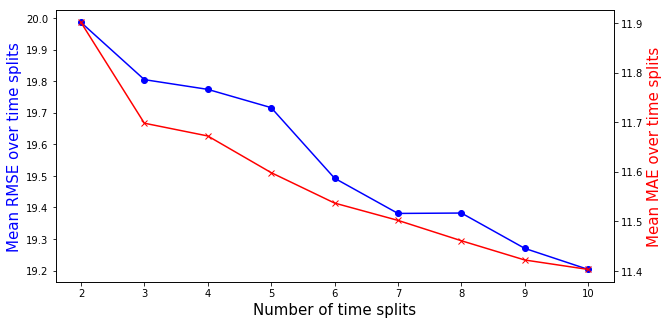

In [137]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(splits, rmse_split, 'bo-')

ax2 = ax1.twinx()
ax2.plot(splits, mae_split, 'rx-')
ax1.set_xlabel("Number of time splits", fontsize=15)
ax1.set_ylabel("Mean RMSE over time splits", color='b', fontsize=15)
ax2.set_ylabel("Mean MAE over time splits", color='r', fontsize=15);

The CV displays a best result for 10 time splits, AND the model seems better than the main Ridge Regression with all airports and all airlines

# 9) Model to keep

The best model so far seems to be the ONE airline / ONE airport model. And this makes sens.

In fact if an airline or an airport is reasponsible for more delays than other airlines or other airports, learning over all airlines or airports won't necessarily help in predicting delays for our specific airline or airport.

Last grid search for our test model :

In [153]:
with open(path + '/data/data_2016_1_airline_1_aiport.pkl', 'rb') as f :
    data_1_airline_1_aiport = pickle.load(f)
print("%i entries for this airport and this airline" % data_1_airline_1_aiport.shape[0])

80917 entries for this airport and this airline


Standardise departure time

In [154]:
std_scale = preprocessing.StandardScaler().fit(data_1_airline_1_aiport.loc[:, ['TIME_SECONDS', 'ARR_TIME_SECS', 'DISTANCE']].values)
data_num_1_airline_1_airport = pd.DataFrame(std_scale.transform(data_1_airline_1_aiport.loc[:, ['TIME_SECONDS', 'ARR_TIME_SECS', 'DISTANCE']].values), columns=['DEP_TIME_SECS_STD', 'ARR_TIME_SECS_STD', 'DISTANCE_STD'])
# Reindex
data_num_1_airline_1_airport.index = data_1_airline_1_aiport.index
# Concat
data_1_airline_1_aiport_reg = pd.concat((data_1_airline_1_aiport['ARR_DELAY_NEW'], data_num_1_airline_1_airport), axis=1)

In [155]:
data_1_airline_1_aiport_reg.head(2)

,ARR_DELAY_NEW,DEP_TIME_SECS_STD,ARR_TIME_SECS_STD,DISTANCE_STD
339550,0.0,-1.575404,-1.140637,1.489495
339642,0.0,-1.426590,-0.718927,0.377094


In [156]:
# Target : arrival delay
y = data_1_airline_1_aiport_reg.loc[:, 'ARR_DELAY_NEW']
X = data_1_airline_1_aiport_reg.loc[:, data_1_airline_1_aiport_reg.columns  != 'ARR_DELAY_NEW']

From previous test we saw that splitting our dataset in 7 time splits gave the smallest RMSE

In [157]:
n_splits = 7
# Create time splits
tscv = model_selection.TimeSeriesSplit(n_splits=n_splits)

# Initialise outputs
errors_cv = []

best_rmse = 9999
# Model
model = linear_model.LinearRegression()
best_model = copy.deepcopy(model)
# Training and testing sets
X_train_final = X
y_train_final = y
X_test_final = X
y_test_final = y

# Time cross-validation
for train_index, test_index in tscv.split(X):
    # Create train and test sets
    X_train_cv, X_test_cv = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Training the model with training set
    model.fit(X_train_cv, y_train_cv)
    
    # Prediction
    prediction = model.predict(X_test_cv)
    # Get Root Mean Squared Error
    mse = metrics.mean_squared_error(y_test_cv, prediction)
    rmse = math.sqrt(mse)
    # Get Mean Absolute Error
    mae = metrics.mean_absolute_error(y_test_cv, prediction)
    # Get Determination Coefficient
    r2 = metrics.r2_score(y_test_cv, prediction)
    
    if rmse < best_rmse :
        best_rmse = rmse
        best_model = copy.deepcopy(model)
        X_train_final = X_train_cv
        y_train_final = y_train_cv
        X_test_final = X_test_cv
        y_test_final = y_test_cv
        
    # Save errors
    errors_cv.append([rmse, mae, r2])

In [158]:
display_metrics("Linear regression on training set", best_model, X_train_final, y_train_final)
display_metrics("Linear regression on testing set", best_model, X_test_final, y_test_final);

Linear regression on training set : RMSE : 18.62, MAE : 11.11, R² : 0.03
Linear regression on testing set : RMSE : 14.34, MAE : 9.49, R² : -0.01


# 10) Prophet prediction over mean delays by day - WORK TO BE DONE

The best model so far seems to be the ONE airline / ONE airport model. Instead of using linear regression or other kind of regression over flight departure time, let's try to forecast delays based on our time-serie.

Loading prophet module

In [165]:
from fbprophet import Prophet

Loading data for one airline and one airport

In [166]:
# Getting current path
path = os.getcwd()
with open(path + '/data/data_2016_1_airline_1_aiport_prophet.pkl', 'rb') as f :
    data_1_airline_1_aiport_prophet = pickle.load(f)
print("%i entries for this airport and this airline" % data_1_airline_1_aiport_prophet.shape[0])

80917 entries for this airport and this airline


Converting date time to date (prophet requirement)

In [167]:
data_1_airline_1_aiport_prophet.loc[:, 'ds'] = data_1_airline_1_aiport_prophet.loc[:, 'DATE_TIME'].apply(lambda x : x.date())

Looking at our data

In [168]:
data_1_airline_1_aiport_prophet.head()

,TAIL_NUM,ORIGIN_CITY_NAME,ARR_DELAY_NEW,DISTANCE,DATE_TIME,TIME_SECONDS,ARR_TIME_SECS,ds
339550,N707SA,"Chicago, IL",0.0,1521.0,2016-01-01 06:15:00,22500,30240.0,2016-01-01
339642,N8645A,"Chicago, IL",0.0,997.0,2016-01-01 07:00:00,25200,39360.0,2016-01-01
339605,N8614M,"Chicago, IL",0.0,1444.0,2016-01-01 07:25:00,26700,38400.0,2016-01-01
339573,N8318F,"Chicago, IL",0.0,990.0,2016-01-01 07:30:00,27000,40560.0,2016-01-01
339512,N8631A,"Chicago, IL",0.0,793.0,2016-01-01 07:45:00,27900,37440.0,2016-01-01


In [188]:
max_aircraft = data_1_airline_1_aiport_prophet['TAIL_NUM'].value_counts().index.values[0]
data_1_airline_1_aiport_prophet = data_1_airline_1_aiport_prophet[data_1_airline_1_aiport_prophet['TAIL_NUM'] == max_aircraft]

Initialise prophet dataset

Aggregating delays by day

In [189]:
data_mean = pd.DataFrame(columns=['ds', 'y'])
data_mean.loc[:, 'ds'] = data_1_airline_1_aiport_prophet.loc[:, 'ds'].unique()
data_mean.loc[:, 'y'] = data_1_airline_1_aiport_prophet.loc[:, 'ARR_DELAY_NEW'].groupby(data_1_airline_1_aiport_prophet.loc[:, 'ds']).apply(lambda x : x.mean()).values
data_mean.head()

,ds,y
0,2016-01-20,0.0
1,2016-01-24,0.0
2,2016-01-25,0.0
3,2016-01-26,2.0
4,2016-01-27,0.0


Standardise target

In [190]:
data_mean.loc[:, 'y_ori'] = data_mean.loc[:, 'y']
std_scale = preprocessing.StandardScaler().fit(data_mean.loc[:, 'y'].values.reshape(-1, 1))
data_mean.loc[:, 'y'] = std_scale.transform(data_mean.loc[:, 'y'].values.reshape(-1, 1))

Train and Test datasets

In [191]:
test_size = 0.3
n_train_mean = math.floor(data_mean.shape[0] * (1 - test_size))

df_train_mean = data_mean.iloc[:n_train_mean, :]
df_test_mean = data_mean.iloc[n_train_mean:, :]

Prophet model

In [192]:
prophet_model = Prophet() #instantiate Prophet
prophet_model.fit(df_train_mean); #fit the model with your dataframe

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\simon\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Prophet future (testing) data to predict over

In [193]:
first_test_day = df_test_mean.loc[:,'ds'].iloc[0]
last_test_day = df_test_mean.loc[:,'ds'].iloc[-1]
delta_days_test = last_test_day - first_test_day
print("First day : %r, Last day : %r, Number of testing days : %i" % (first_test_day, last_test_day, delta_days_test.days + 1))
date_list_test = [first_test_day + datetime.timedelta(days=x) for x in range(0, delta_days_test.days + 1)]
future_data = pd.DataFrame(data=date_list_test, columns=['ds'])

First day : datetime.date(2016, 9, 8), Last day : datetime.date(2016, 12, 28), Number of testing days : 112


Prophet past (training) data to predict over

In [194]:
first_train_day = df_train_mean.loc[:,'ds'].iloc[0]
last_train_day = df_train_mean.loc[:,'ds'].iloc[-1]
delta_days_train = last_train_day - first_train_day
print("First day : %r, Last day : %r, Number of training days : %i" % (first_train_day, last_train_day, delta_days_train.days))
date_list_train = [first_train_day + datetime.timedelta(days=x) for x in range(0, delta_days_train.days)]
past_data = pd.DataFrame(data=date_list_train, columns=['ds'])

First day : datetime.date(2016, 1, 20), Last day : datetime.date(2016, 9, 7), Number of training days : 231


Prophet forecast

In [195]:
forecast_data = prophet_model.predict(future_data)
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-09-08,0.139028,-1.177910,1.231490,0.139028,0.139028,-0.178241,-0.178241,-0.178241,-0.178241,-0.178241,-0.178241,0.0,0.0,0.0,-0.039213
1,2016-09-09,0.139781,-1.208161,1.258389,0.139781,0.139781,-0.101532,-0.101532,-0.101532,-0.101532,-0.101532,-0.101532,0.0,0.0,0.0,0.038249
2,2016-09-10,0.140533,-0.958504,1.450355,0.140533,0.140533,0.071276,0.071276,0.071276,0.071276,0.071276,0.071276,0.0,0.0,0.0,0.211810
3,2016-09-11,0.141286,-1.099904,1.483127,0.141286,0.141286,0.056894,0.056894,0.056894,0.056894,0.056894,0.056894,0.0,0.0,0.0,0.198180
4,2016-09-12,0.142038,-1.407673,1.170467,0.142038,0.142038,-0.327769,-0.327769,-0.327769,-0.327769,-0.327769,-0.327769,0.0,0.0,0.0,-0.185730


In [196]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-09-08,-0.039213,-1.177910,1.231490
1,2016-09-09,0.038249,-1.208161,1.258389
2,2016-09-10,0.211810,-0.958504,1.450355
3,2016-09-11,0.198180,-1.099904,1.483127
4,2016-09-12,-0.185730,-1.407673,1.170467


Plotting results

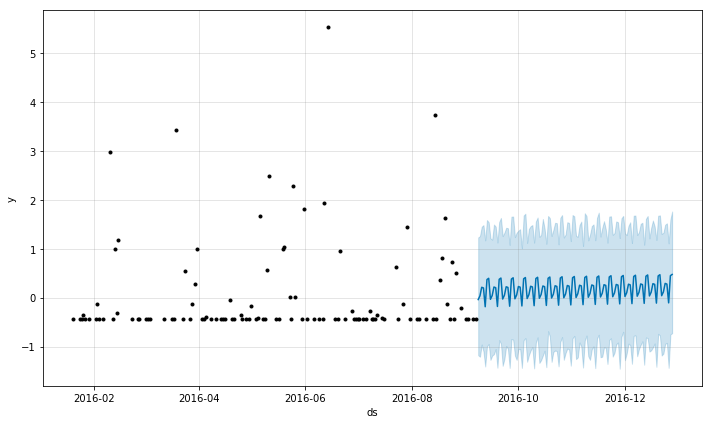

In [197]:
prophet_model.plot(forecast_data);

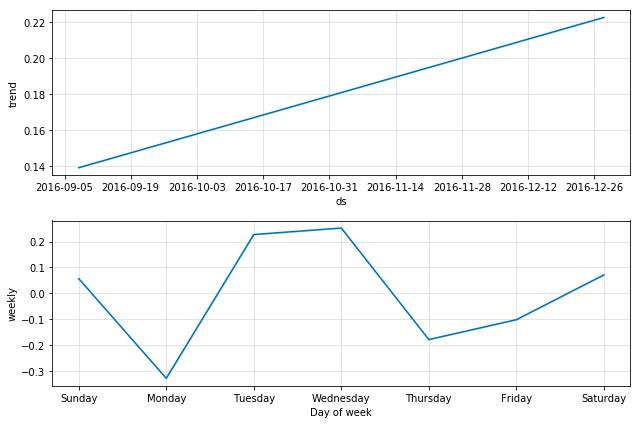

In [198]:
prophet_model.plot_components(forecast_data);

Scaling back results to compare to reality

In [199]:
forecast_data['y_or'] = std_scale.inverse_transform(forecast_data['yhat'])
forecast_data['y_l_or'] = std_scale.inverse_transform(forecast_data['yhat_lower'])
forecast_data['y_h_or'] = std_scale.inverse_transform(forecast_data['yhat_upper'])

ValueError: x and y must have same first dimension, but have shapes (112,) and (49,)

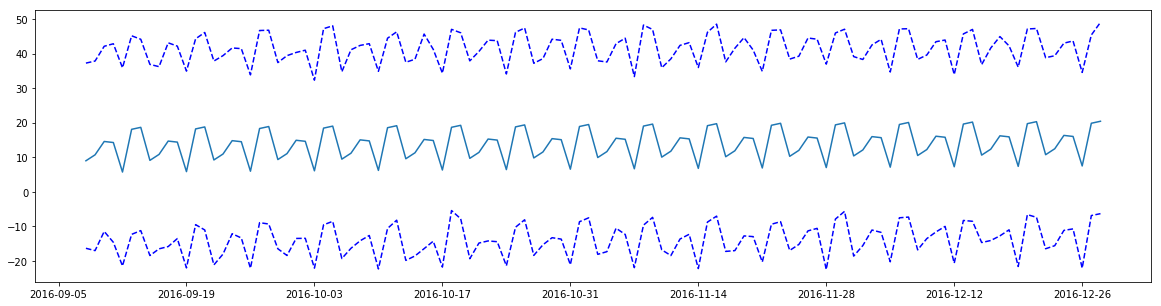

In [200]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(forecast_data['ds'], forecast_data['y_or'])
plt.plot(forecast_data['ds'], forecast_data['y_l_or'], 'b--')
plt.plot(forecast_data['ds'], forecast_data['y_h_or'], 'b--')
plt.plot(forecast_data['ds'], df_test_mean['y_ori'])
ax.set_xlabel("Testing Days")
ax.set_ylabel("Daily mean delay");

In [ ]:
rmse_test = math.sqrt(metrics.mean_squared_error(df_test_mean['y_ori'].values, forecast_data['y_or'].values))
mae_test = metrics.mean_absolute_error(df_test_mean['y_ori'].values, forecast_data['y_or'].values)
print("RMSE on testing dataset : %.2f" % rmse_test)
print("MAE on testing dataset : %.2f" % mae_test)

In [201]:
train_predict = std_scale.inverse_transform(prophet_model.predict(past_data)['yhat'])
rmse_train = math.sqrt(metrics.mean_squared_error(df_train_mean['y'].values, train_predict))
mae_train = metrics.mean_absolute_error(df_train_mean['y'].values, train_predict)
print("RMSE on training dataset : %.2f" % rmse_train)
print("MAE on training dataset : %.2f" % mae_train)

ValueError: Found input variables with inconsistent numbers of samples: [112, 231]

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(past_data['ds'], train_predict)
plt.plot(past_data['ds'], df_train_mean['y_ori'])
ax.set_xlabel("Training Days")
ax.set_ylabel("Daily mean delay");

In [ ]:
# del X, X_train_std, ax1, ax2, data, data_reg, label_airlines, oh_airlines, oh_dep_airport, pred_df, predict_df

In [ ]:
whos